## Question 01

C:\Users\chris\AppData\Local\Temp\ipykernel_3844\3371162366.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


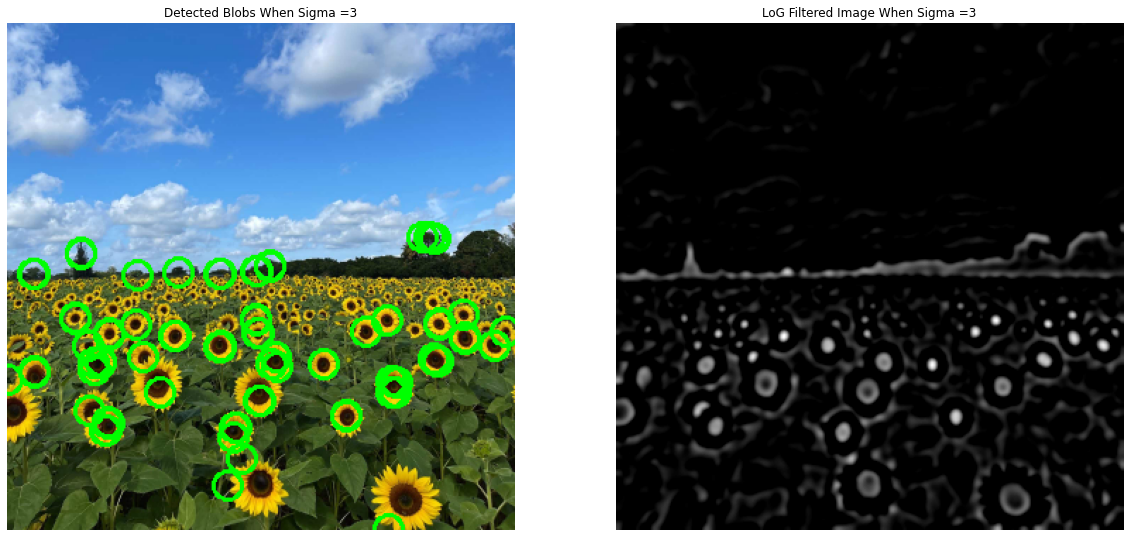

In [24]:
# Import main libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Load the image
image = cv.imread('Images/the_berry_farms_sunflower_field.jpeg', cv.IMREAD_REDUCED_COLOR_4)
gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Define the LoG filter parameters
sigma = 3
hw = 3 * sigma
X, Y = np.meshgrid(np.arange(-hw, hw + 1, 1), np.arange(-hw, hw + 1, 1))
LoG_filter = 1 / (2 * np.pi * sigma**2) * (X**2 / (sigma**2) + Y**2 / (sigma**2) - 2) * np.exp(-(X**2 + Y**2) / (2 * sigma**2))

# Apply the LoG filter to the grayscale image using convolution
filtered_image = cv.filter2D(gray, -1, LoG_filter)

# Find local maxima in the filtered image
local_maxima = (filtered_image == cv.dilate(filtered_image, np.ones((3, 3))))

# Get the coordinates of the detected local maxima
maxima_coordinates = np.argwhere(local_maxima)

# Create a list of detected blobs as (x, y) coordinates and corresponding radii
blobs = []
threshold = 48
for coord in maxima_coordinates:
    if filtered_image[coord[0], coord[1]] > threshold:
        blobs.append((coord[1], coord[0]))  # Note the order (x, y)

# Draw the detected blobs on the original image
result = image.copy()
for blob in blobs:
    cv.circle(result, blob, 10, (0, 255, 0), 2) 

# Display the result
plt.subplots(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.title("Detected Blobs When Sigma =" + str(sigma))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(filtered_image, cmap='gray')
plt.title("LoG Filtered Image When Sigma =" + str(sigma))
plt.axis('off')

plt.show()

Number of detected blobs: 79


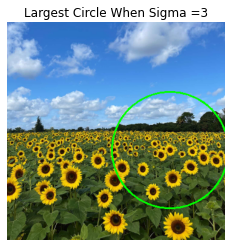

Parameters of the largest circle:
Center: (269, 211)
Radius: 96


In [25]:
# Report the number of detected blobs
print("Number of detected blobs:", len(blobs))

# Sort the detected blobs by radius in descending order
blobs.sort(key=lambda x: filtered_image[x[1], x[0]], reverse=True)

# Extract the parameters of the largest circle
if blobs:
    largest_blob = blobs[0]
    largest_radius = filtered_image[largest_blob[1], largest_blob[0]]
    largest_circle_params = (largest_blob[0], largest_blob[1], largest_radius)

    # Draw the largest circle on the original image
    result = image.copy()
    cv.circle(result, (largest_blob[0], largest_blob[1]), int(largest_radius), (0, 255, 0), 2)

    # Display the result
    plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
    plt.title("Largest Circle When Sigma =" + str(sigma))
    plt.axis('off')
    plt.show()

    # Print the parameters of the largest circle
    print("Parameters of the largest circle:")
    print(f"Center: ({largest_blob[0]}, {largest_blob[1]})")
    print(f"Radius: {largest_radius}")
else:
    print("No blobs found.")

## Question 02

In [1]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import tikzplotlib
import math

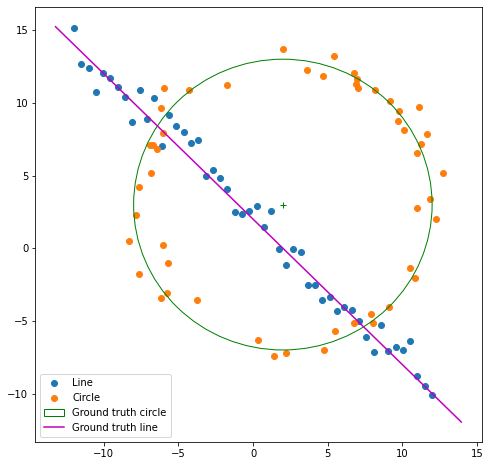

In [2]:
# Constants
N = 100
half_n = N // 2
r = 10
x0_gt, y0_gt = 2, 3  # Center
s = r / 16

# Generate random points for the circle
t = np.random.uniform(0, 2 * np.pi, half_n)
n = s * np.random.randn(half_n)
x = x0_gt + (r + n) * np.cos(t)
y = y0_gt + (r + n) * np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Generate random points for the line
s = 1.0
m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m * x + b + s * np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

# Combine all points
X = np.vstack((X_circ, X_line))

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot for the line points
ax.scatter(X_line[:, 0], X_line[:, 1], label='Line')

# Scatter plot for the circle points
ax.scatter(X_circ[:, 0], X_circ[:, 1], label='Circle')

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = m * x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')

plt.legend()
plt.show()


In [3]:
N = X.shape[0]
dataset = X
def line_equation_from_points(x1, y1, x2, y2):
    # Return the line equation in the form ax + by = d
    # Calculate the direction vector (Δx, Δy)
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Calculate the normalized vector (a, b)
    magnitude = math.sqrt(delta_x**2 + delta_y**2)
    a = delta_y / magnitude
    b = -delta_x / magnitude

    # Calculate d
    d = (a * x1) + (b * y1)

    return a, b, d

def line_tls(x, indices):
    # Return the total least squares error for the line model
    a, b, d = x[0], x[1], x[2]
    return np.sum(np.square(a*dataset[indices,0] + b*dataset[indices,1] - d))

def g(x):
    # Constraint 
    return x[0]**2 + x[1]**2 - 1

cons = ({'type': 'eq', 'fun': g})

def consensus_line(X, x, t):
    # Computing the inliners
    a, b, d = x[0], x[1], x[2]
    error = np.absolute(a*dataset[:,0] + b*dataset[:,1] - d)
    return error < t

Optimization terminated successfully    (Exit mode 0)
            Current function value: 3.219478884637398e-10
            Iterations: 10
            Function evaluations: 43
            Gradient evaluations: 10
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7.081412680369378e-09
            Iterations: 24
            Function evaluations: 121
            Gradient evaluations: 24
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2.1003872246034188e-07
            Iterations: 6
            Function evaluations: 28
            Gradient evaluations: 6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.009726533552159e-12
            Iterations: 13
            Function evaluations: 58
            Gradient evaluations: 13
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.084736009079027e-10
            Iterations: 8
          

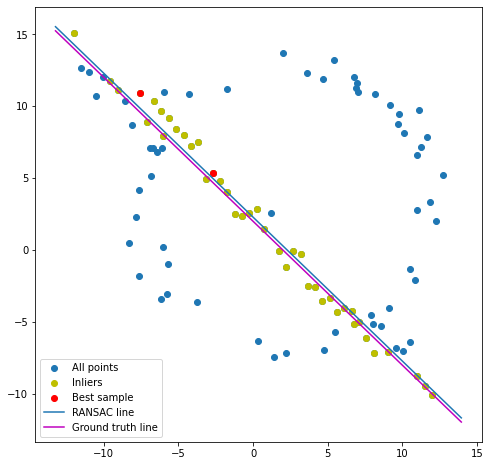

In [4]:
t = 1.   # Threshold value to determine data points that are fit well by model.
d = 0.4*N   # Number of close data points required to assert that a model fits well to data.
s = 2       # Minimum number of data points required to estimate model parameters.

inliers_line = []        # Indices of the inliers
max_iterations = 50
iteration = 0
best_model_line = []     # Best model normal (a, b) and distance from origin d
best_error = np.inf
best_sample_line = []    # Three-point sample leading to the best model computation
res_only_with_sample = [] # Result (a, b, d) only using the best sample
best_inliers_line = []   # Inliers of the model computed form the best sample

while iteration < max_iterations:   
    indices = np.random.randint(0, N, s) # A sample of three (s) points selected at random
    x0 = np.array([1, 1, 0]) # Initial estimate
    res = minimize(fun = line_tls, args = indices, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
    inliers_line = consensus_line(dataset, res.x, t) # Computing the inliers
    #print('rex.x: ', res.x)    
    #print('Iteration = ', iteration, '. No. inliners = ', inliers_line.sum())
    if inliers_line.sum() > d:
        x0 = res.x
        # Computing the new model using the inliers
        res = minimize(fun = line_tls, args = inliers_line, x0 = x0, tol= 1e-6, constraints=cons, options={'disp': True})
        #print(res.x, res.fun)
        if res.fun < best_error:
            #print('A better model found ... ', res.x, res.fun)
            best_model_line = res.x
            best_eror = res.fun
            best_sample_line = dataset[indices,:]
            res_only_with_sample = x0
            best_inliers_line = inliers_line

    iteration += 1

print('Best line model', best_model_line)

print(dataset.shape)
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best sample')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')
plt.legend()

(59, 2)


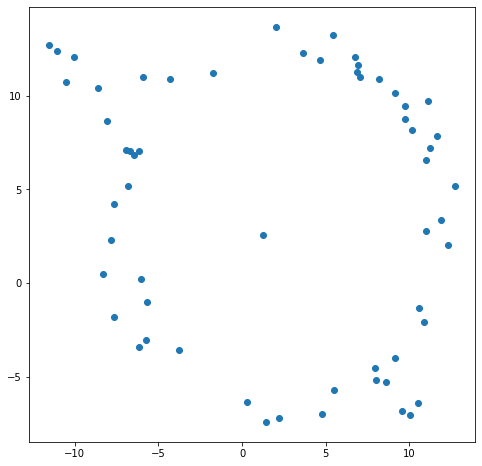

In [5]:
from scipy import optimize
import random

# Extract the outliers (data points that are not inliers)
outliers_indices = np.where(np.logical_not(best_inliers_line))[0]
#print('Outliers indices', outliers_indices)
outliers_data = dataset[outliers_indices, :]
# print(outliers_data)
print(outliers_data.shape)

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(outliers_data[:,0],outliers_data[:,1], label='All points')

N = outliers_data.shape[0]

def circle_equation(points):
    # Return the center and radius of the circle from three points 
    p1,p2,p3 = points[0], points[1], points[2]
    temp = p2[0] * p2[0] + p2[1] * p2[1]
    bc = (p1[0] * p1[0] + p1[1] * p1[1] - temp) / 2
    cd = (temp - p3[0] * p3[0] - p3[1] * p3[1]) / 2
    det = (p1[0] - p2[0]) * (p2[1] - p3[1]) - (p2[0] - p3[0]) * (p1[1] - p2[1])

    # Center of circle
    cx = (bc*(p2[1] - p3[1]) - cd*(p1[1] - p2[1])) / det
    cy = ((p1[0] - p2[0]) * cd - (p2[0] - p3[0]) * bc) / det

    radius = np.sqrt((cx - p1[0])**2 + (cy - p1[1])**2)
    return ((cx, cy), radius)

def get_inliers(data_list, center, r):
    # Returns the list of inliers to a model of a circle from a set of points. The threshold value is taken as 1/5th of the radius 
    inliers = []
    thresh = r//3

    for i in range(len(data_list)):
        error = np.sqrt((data_list[i][0]-center[0])**2 + (data_list[i][1]-center[1])**2) - r
        if error < thresh:
            inliers.append(data_list[i])

    return np.array(inliers)

def random_sample(data_list):
    # Returns a list of 3 random samples from a given list 
    sample_list = []
    random.seed(0)
    rand_nums = random.sample(range(1, len(data_list)), 3)
    for i in rand_nums:
        sample_list.append(data_list[i])
    return np.array(sample_list)

def calc_R(x_, y_, xc, yc):
    # calculate the distance of each 2D points from the center (xc, yc) 
    return np.sqrt((x_-xc)**2 + (y_-yc)**2)

def f_2(c, x_, y_):
    # calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) 
    Ri = calc_R(x_, y_, *c)
    return Ri - Ri.mean()

def estimateCircle(x_m, y_m, points):
    x_ = points[:,0]
    y_ = points[:,1]
    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate, (x_, y_))

    xc_2, yc_2 = center_2

    Ri_2 = calc_R(x_, y_, *center_2)
    R_2 = Ri_2.mean()
    # residu_2   = sum((Ri_2 - R_2)**2)
    return (xc_2, yc_2), R_2

In [12]:
# RANSAC_Circle
def RANSAC_Circle(data_list, itr):
    # Return the center, radius and the best sample and its inliers used to fit the circle to a set of points using RANSAC_Circle 
    best_sample = []
    best_center_sample = (0,0)
    best_radius_sample = 0
    best_inliers = []
    max_inliers = len(data_list)*0.9
    
    for i in range(itr):
        samples = random_sample(data_list)  
        center, radius = circle_equation(samples) 
        inliers = get_inliers(data_list, center, radius) 
        num_inliers = len(inliers)

        # If a better approximation has been reached
        if num_inliers > max_inliers:
            best_sample = samples
            max_inliers = num_inliers
            best_center_sample = center
            best_radius_sample = radius
            best_inliers = inliers


    print("Center of Sample=", best_center_sample)
    print("Radius of Sample=", best_radius_sample)

    return best_center_sample, best_radius_sample, best_sample, best_inliers

Center of Sample= (-1.805719762883989, 1.7335830388690787)
Radius of Sample= 12.533579968682517
(59, 2)
Ratio of inliers = 118.0 %
Center of RANSAC = (1.7469426860015722, 3.650193119719488)
Radius of RANSAC = 10.313442606809208


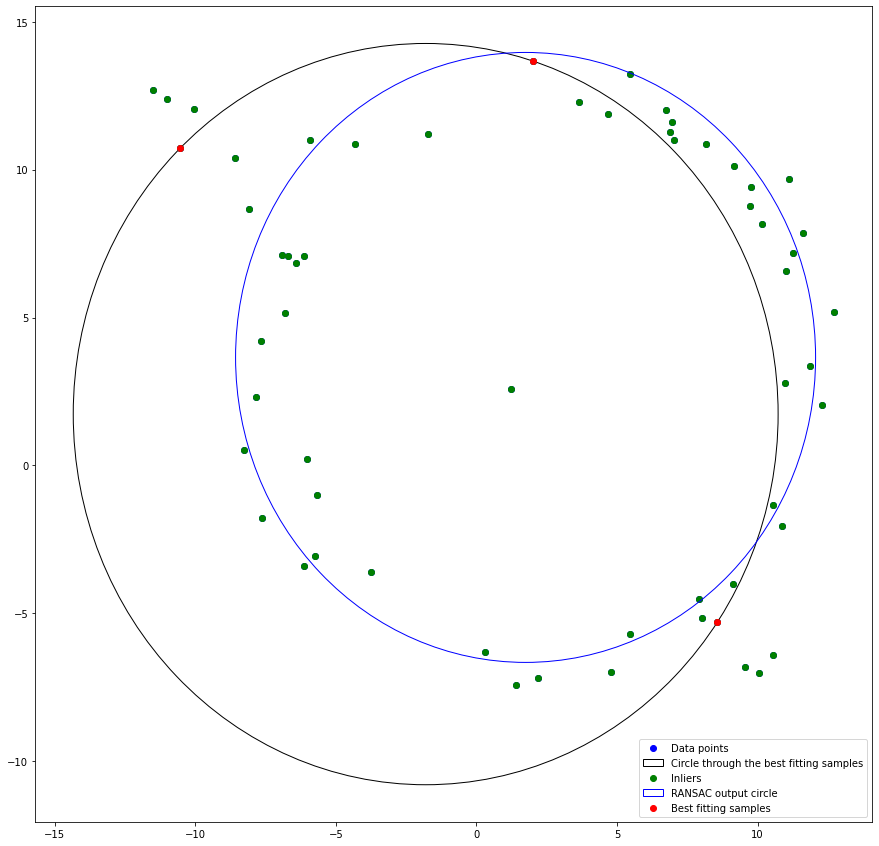

In [13]:
# Calculting the RANSAC outputs for the data set
center, radius, sample, inliers = RANSAC_Circle(outliers_data, 50000)
print(outliers_data.shape)

# Plotting
fig,ax = plt.subplots(1,1, figsize = (15,15))
plt.scatter(outliers_data[:,0], outliers_data[:,1], color = 'blue', label = "Data points")
# Plotting the circle that is created by the best fitting points
circle = plt.Circle(center, radius, fill = False, label = "Circle through the best fitting samples", color = 'k')
ax.add_patch(circle)

# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'green', label = "Inliers")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC output circle", color = 'b')
ax.add_patch(circle)

# Plotting the circle
ax.scatter(sample[:,0], sample[:,1], color = 'red', label = "Best fitting samples")
ax.legend()

Ratio of inliers = 118.0 %
Center of RANSAC = (1.7469426860015722, 3.650193119719488)
Radius of RANSAC = 10.313442606809208


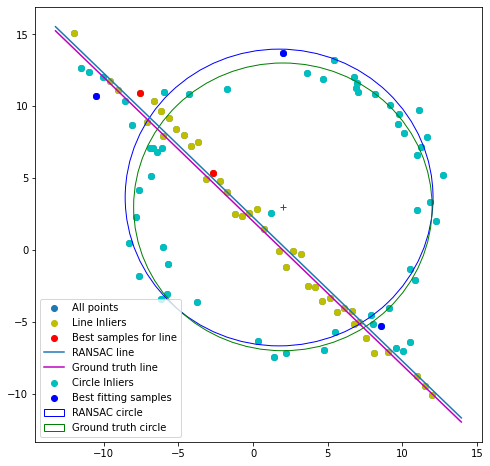

In [14]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.scatter(dataset[:,0],dataset[:,1], label='All points')
ax.scatter(dataset[best_inliers_line,0],dataset[best_inliers_line,1], color='y', label='Line Inliers')
ax.scatter(best_sample_line[:,0],best_sample_line[:,1], color='r', label='Best samples for line')
x_min, x_max = ax.get_xlim()
x_ = np.array([x_min, x_max])
y_ = (-best_model_line[1]*x_ + best_model_line[2])/best_model_line[1]
plt.plot(x_, y_,  label='RANSAC line')
x_ = np.array([x_min, x_max])
y_ = m*x_ + b
plt.plot(x_, y_, color='m', label='Ground truth line')


# Plotting the inliers
print("Ratio of inliers =",len(inliers)/half_n*100, "%")
ax.scatter(inliers[:,0], inliers[:,1], color = 'c', label = "Circle Inliers")

ax.scatter(sample[:,0], sample[:,1], color = 'b', label = "Best fitting samples")

# Estimate the circle using the inliers using the least square method
ransac_center, ransac_radius = estimateCircle(center[0], center[1], inliers)
print("Center of RANSAC =", ransac_center)
print("Radius of RANSAC =", ransac_radius)
circle = plt.Circle(ransac_center, ransac_radius, fill = False, label = "RANSAC circle", color = 'b')
ax.add_patch(circle)

# Ground truth circle
circle_gt = plt.Circle((x0_gt, y0_gt), r, color='g', fill=False, label='Ground truth circle')
ax.add_patch(circle_gt)
ax.plot(x0_gt, y0_gt, '+', color='g')

ax.legend()
plt.legend()

## Question 03

In [15]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

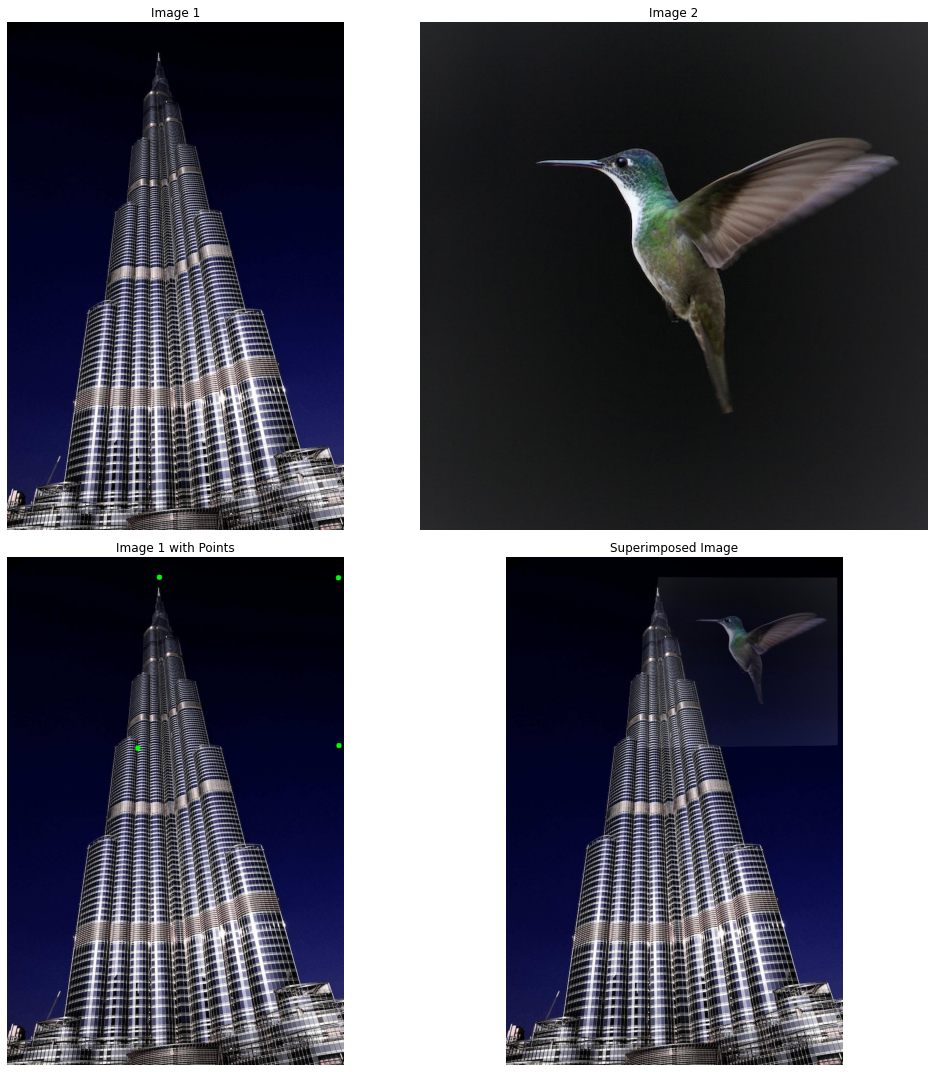

In [16]:
# Read the images
image1 = cv.imread("Images/BK.jpg")
image2 = cv.imread("Images/Bird.jpg")

# Create a list to store the points
points_image1 = []
blended_image = []

# Callback function for mouse events
def click_event(event, x, y, flags, param):
    global points_image1

    # If the left mouse button is clicked, record the point
    if event == cv.EVENT_LBUTTONDOWN:
        points_image1.append((x, y))

        # Draw the selected point on the copy of the image for visualization
        image_with_points = image1.copy()
        cv.circle(image_with_points, (x, y), 5, (0, 255, 0), -1)
        cv.imshow("Image1 with Points", image_with_points)

        # If four points are selected, proceed with further processing
        if len(points_image1) == 4:
            compute_homography()

# Function to compute homography and perform superimposition
def compute_homography():
    global points_image1
    global blended_image

    # Define the corresponding points in image2 (a rectangle with the same aspect ratio as image1)
    points_image2 = np.array([[0, 0], [image2.shape[1], 0], [image2.shape[1], image2.shape[0]], [0, image2.shape[0]]], dtype=np.float32)

    # Compute the homography matrix
    homography_matrix, _ = cv.findHomography(points_image2, np.array(points_image1, dtype=np.float32))

    # Warp image2 to match the perspective of image1
    warped_image2 = cv.warpPerspective(image2, homography_matrix, (image1.shape[1], image1.shape[0]))

    # Blend the images using specified alpha values
    alpha = 0.6 # You can adjust this alpha value as needed
    blended_image = cv.addWeighted(image1, 1, warped_image2, alpha, 0)

    # Display the resulting images
    cv.imshow("Superimposed Image", blended_image)
    cv.waitKey(0)
    cv.destroyAllWindows()


# Show the composite image and set the callback function for mouse events
cv.imshow("Image1 with Points", image1)
cv.setMouseCallback("Image1 with Points", click_event)
cv.waitKey(0)
cv.destroyAllWindows()


# Create a composite image horizontally using Matplotlib
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
axes[0, 0].imshow(cv.cvtColor(image1, cv.COLOR_BGR2RGB))
axes[0, 0].set_title('Image 1')
axes[0, 0].axis('off')

axes[0, 1].imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
axes[0, 1].set_title('Image 2')
axes[0, 1].axis('off')


# Draw the points on a copy of image1
image_with_points = image1.copy()
for point in points_image1:
    cv.circle(image_with_points, point, 5, (0, 255, 0), -1)
axes[1, 0].imshow(cv.cvtColor(image_with_points, cv.COLOR_BGR2RGB))
axes[1, 0].set_title('Image 1 with Points')
axes[1, 0].axis('off')

# Show the final superimposed image
axes[1, 1].imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
axes[1, 1].set_title('Superimposed Image')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


## Question 04

In [17]:
# Import Main Libraries
import cv2 as cv
import numpy as np  
import matplotlib.pyplot as plt

In [18]:
# Load Images
image1 = cv.imread('Images/img1.ppm')
image2 = cv.imread('Images/img5.ppm')

# Convert to Grayscale
gray1 = cv.cvtColor(image1, cv.COLOR_BGR2GRAY)
gray2 = cv.cvtColor(image2, cv.COLOR_BGR2GRAY)

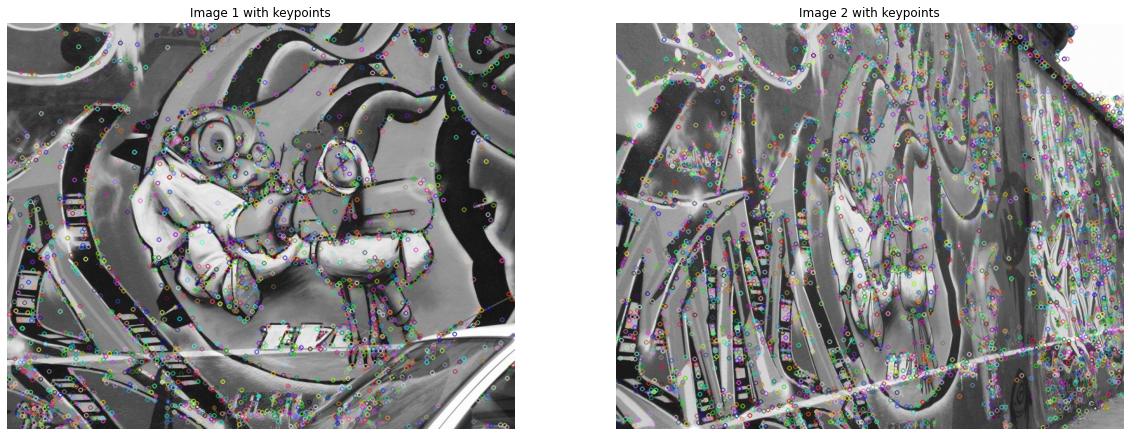

In [19]:
# Initiate SIFT detector
sift = cv.SIFT_create()

# Find the keypoints and descriptors with SIFT
keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

image1_copy = image1.copy()
image2_copy = image2.copy()

# Draw keypoints
image1_with_kp = cv.drawKeypoints(gray1, keypoints1, image1_copy)
image2_with_kp = cv.drawKeypoints(gray2, keypoints2, image2_copy)

# Show Images
plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(image1_with_kp)
plt.title('Image 1 with keypoints')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_with_kp)
plt.title('Image 2 with keypoints')
plt.axis('off')

plt.show()

In [20]:
def compute_homography_RANSAC(matches, keypoints1, keypoints2, num_iterations=1000, initial_threshold=4.0):
    best_homography = None
    best_inliers_count = 0
    
    for _ in range(num_iterations):
        # Randomly select 4 correspondences
        sample_indices = np.random.choice(len(matches), 4, replace=False)
        src_points = np.float32([keypoints1[matches[i].queryIdx].pt for i in sample_indices])
        dst_points = np.float32([keypoints2[matches[i].trainIdx].pt for i in sample_indices])

        # Compute the homography using the selected correspondences
        homography, _ = cv.findHomography(src_points, dst_points, cv.RANSAC, initial_threshold)

        # Count inliers using the computed homography and adaptive thresholding
        inliers_count = 0
        for i, match in enumerate(matches):
            src_pt = keypoints1[match.queryIdx].pt
            dst_pt = keypoints2[match.trainIdx].pt
            src_pt_hom = np.array([src_pt[0], src_pt[1], 1.0])
            projected_pt = np.dot(homography, src_pt_hom)
            projected_pt /= projected_pt[2]
            error = np.linalg.norm(np.array([dst_pt[0], dst_pt[1], 1.0]) - projected_pt)
            if error < initial_threshold:
                inliers_count += 1

        # Keep the homography with the most inliers
        if inliers_count > best_inliers_count:
            best_homography = homography
            best_inliers_count = inliers_count

    return best_homography, best_inliers_count


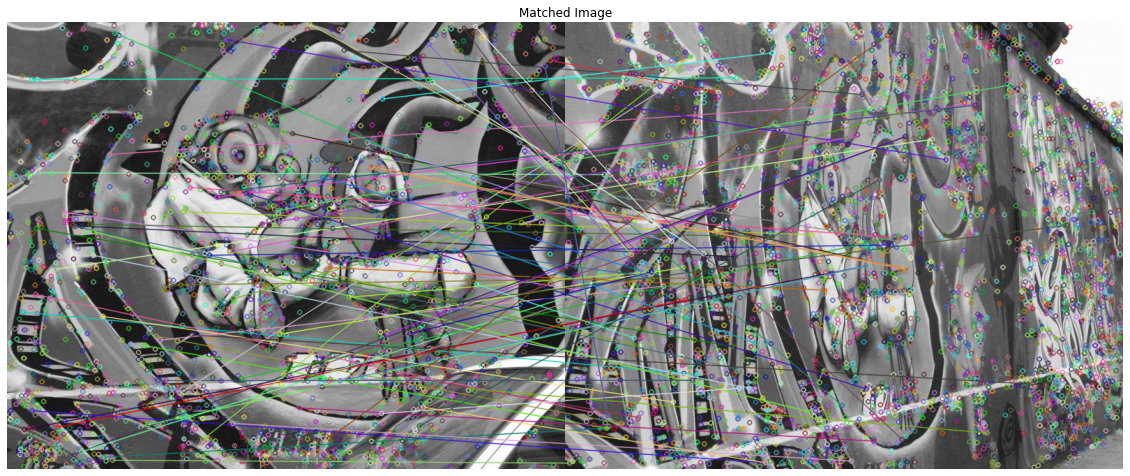

In [21]:
# Create a BFMatcher (Brute Force Matcher) with default parameters
bf = cv.BFMatcher()

# Match descriptors between the two images
matches = bf.knnMatch(descriptors1, descriptors2, k=2)

# Apply ratio test to filter good matches
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

# Draw the matches on a new image
matched_image = cv.drawMatches(gray1, keypoints1, gray2, keypoints2, good_matches, None)

# Plot the matched image
plt.figure(figsize=(20, 20))
plt.imshow(matched_image)
plt.title('Matched Image')
plt.axis('off')
plt.show()

In [22]:
# Compute the homography using RANSAC
best_homography, best_inliers_count = compute_homography_RANSAC(good_matches, keypoints1, keypoints2)

# Compare with a known homography matrix (replace with your dataset's homography)
known_homography = np.array([[6.2544644e-01  ,5.7759174e-02   ,2.2201217e+02],
                    [2.2240536e-01  ,1.1652147e+00  ,-2.5605611e+01],
                    [4.9212545e-04 ,-3.6542424e-05  , 1.0000000e+00]] )

error = np.linalg.norm(known_homography - best_homography)

print("Computed Homography:")
print(best_homography)
print("\nKnown Homography:")
print(known_homography)
print("\nHomography Error:", error)

C:\Users\chris\AppData\Local\Temp\ipykernel_3844\1337165914.py:21: RuntimeWarning: divide by zero encountered in divide
  projected_pt /= projected_pt[2]
C:\Users\chris\AppData\Local\Temp\ipykernel_3844\1337165914.py:21: RuntimeWarning: invalid value encountered in divide
  projected_pt /= projected_pt[2]


Computed Homography:
[[-6.18935635e-01 -5.93977023e-01  4.24503959e+02]
 [-5.03927855e-01 -4.88498332e-01  3.48577376e+02]
 [-1.44440538e-03 -1.40158893e-03  1.00000000e+00]]

Known Homography:
[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]

Homography Error: 425.46570739389364


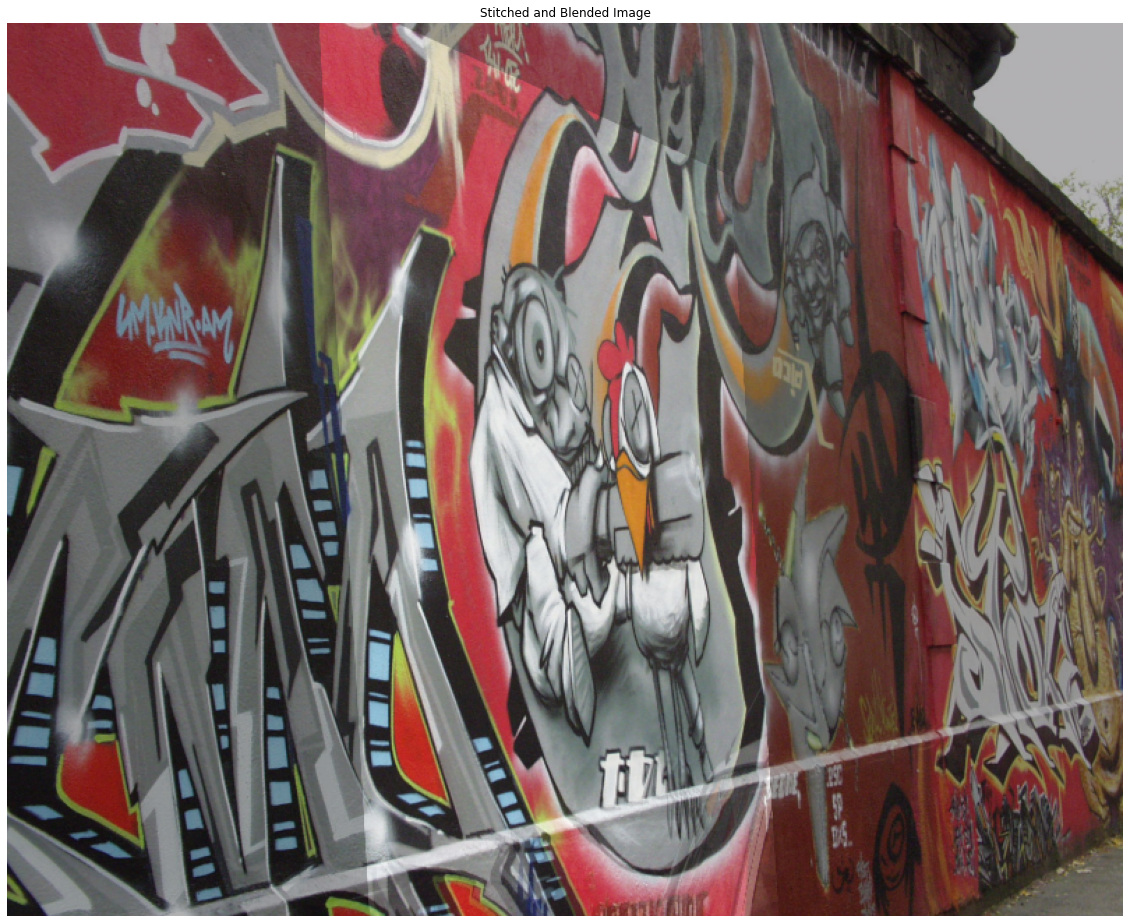

In [23]:
# Warp image1 to align it with image5
stitched_image = cv.warpPerspective(image1, known_homography, (image2.shape[1], image2.shape[0]))

# Blend the two images to create a seamless result
alpha = 0.3  # Adjust the alpha value for different blending effects
beta = 1 - alpha
blended_image = cv.addWeighted(stitched_image, alpha, image2, beta, 0.0)

# Plot the stitched and blended image
plt.figure(figsize=(20, 20))
plt.imshow(cv.cvtColor(blended_image, cv.COLOR_BGR2RGB))
plt.title('Stitched and Blended Image')
plt.axis('off')
plt.show()